In [1]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchmetrics import R2Score

r2score = R2Score()

torch.manual_seed(2)
np.random.seed(2)
torch.set_printoptions(precision=8)

In [2]:
# Sigma function
def sigma(t, k, n):
    a = np.array([])
    for i in range(n):
        for j in range(k):
            a = np.append(a, i+1)
    a = torch.tensor(a, dtype=torch.float32)
    alpha = 16
    return 1 - torch.sigmoid(alpha*(a-t-0.5))

In [3]:
# Model
class Net(torch.nn.Module):
  def __init__(self, n=4, p=8, noi=1, noo=1):
    super(Net, self).__init__()
    self.n   = n
    self.p   = p
    self.noi = noi
    self.noo = noo
    self.k   = int(self.p/self.n)
    
    # Branch x0
    self.input_x0  = torch.nn.Linear(self.noo, 16)
    self.hidden_x0 = torch.nn.Linear(16, 16)
    self.output_x0 = torch.nn.Linear(16, self.p*self.noo)

    # Branch 1 u
    self.input1_u  = torch.nn.Linear(self.noi, 4)
    self.hidden1_u = torch.nn.Linear(4, 4)
    self.output1_u = torch.nn.Linear(4, self.k*self.noo)

    # Branch 2 u
    self.input2_u  = torch.nn.Linear(self.noi, 4)
    self.hidden2_u = torch.nn.Linear(4, 4)
    self.output2_u = torch.nn.Linear(4, self.k*self.noo)

    # Branch 3 u
    self.input3_u  = torch.nn.Linear(self.noi, 4)
    self.hidden3_u = torch.nn.Linear(4, 4)
    self.output3_u = torch.nn.Linear(4, self.k*self.noo)

    # Branch 4 u
    self.input4_u  = torch.nn.Linear(self.noi, 4)
    self.hidden4_u = torch.nn.Linear(4, 4)
    self.output4_u = torch.nn.Linear(4, self.k*self.noo)

    # Trunk
    self.input_t   = torch.nn.Linear(1, 16)
    self.hidden_t  = torch.nn.Linear(16, 16)
    self.output_t  = torch.nn.Linear(16, self.p*self.noo)

  def forward(self, x0, u, t):
    # h
    h = torch.relu(self.input_x0(x0))
    h = torch.relu(self.hidden_x0(h))
    h = self.output_x0(h)

    # f
    f1 = torch.relu(self.input1_u(u[:,0:1*self.noi].reshape(-1,self.noi)))
    f1 = torch.relu(self.hidden1_u(f1))
    f1 = self.output1_u(f1)

    f2 = torch.relu(self.input2_u(u[:,1*self.noi:2*self.noi].reshape(-1,self.noi)))
    f2 = torch.relu(self.hidden2_u(f2))
    f2 = self.output2_u(f2)

    f3 = torch.relu(self.input3_u(u[:,2*self.noi:3*self.noi].reshape(-1,self.noi)))
    f3 = torch.relu(self.hidden3_u(f3))
    f3 = self.output3_u(f3)

    f4 = torch.relu(self.input4_u(u[:,3*self.noi:4*self.noi].reshape(-1,self.noi)))
    f4 = torch.relu(self.hidden4_u(f4))
    f4 = self.output4_u(f4)

    f = torch.cat((f1, f2, f3, f4), dim=1)

    # sigma
    s = sigma(t, self.k*self.noo, self.n)

    # g
    g = torch.relu(self.input_t(t))
    g = torch.relu(self.hidden_t(g))
    g = self.output_t(g)

    # y
    y = (h*f*g*s).reshape(-1, self.p, self.noo)
    y = torch.sum(y, 1)
    
    return y

In [4]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x0_data, testset.u_data, testset.t_data)

    r2_y1 = r2score(pred_Y[:,0], testset.y_data[:,0])
    r2_y2 = r2score(pred_Y[:,1], testset.y_data[:,1])
    
    return r2_y1.item(), r2_y2.item()

In [5]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, n, H, noi, noo):
    self.n   = n
    self.H   = H
    self.noi = noi
    self.noo = noo
    self.src_file = src_file
    df = pd.read_csv(self.src_file, header=None)

    X0, U, T, Y = np.array([[1,1]], dtype=np.float32), np.ones((1, n*self.noi)), np.array([[1]], dtype=np.float32), np.array([[1,1]], dtype=np.float32)
    for i in range(df.shape[0]):
        row = np.array(df.iloc[i])
        for j in range(self.H - self.n):
            x0 = np.array([[row[self.H*self.noi + self.noo*j], row[self.H*self.noi + self.noo*j + 1]]])
            u  = np.array([row[j:j + self.n*self.noi]])
            for t in range(1, self.n + 1):
                y = np.array([[row[self.H*self.noi + self.noo*j + t], row[self.H*self.noi + self.noo*j + 1 + t]]])
                t = np.array([[t]])

                X0 = np.concatenate((X0, x0))
                U  = np.concatenate((U, u))
                T  = np.concatenate((T, t))
                Y  = np.concatenate((Y, y))

    X0, U, T, Y = X0[1:], U[1:], T[1:], Y[1:]

    self.x0_data = torch.tensor(X0, dtype=torch.float32)
    self.u_data  = torch.tensor(U,  dtype=torch.float32)
    self.t_data  = torch.tensor(T,  dtype=torch.float32)
    self.y_data  = torch.tensor(Y,  dtype=torch.float32)

  def __len__(self):
    return len(self.x0_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    x0  = self.x0_data[idx]
    u   = self.u_data[idx]
    t   = self.t_data[idx]
    y   = self.y_data[idx]
    sample = {'x0':x0, 'u':u, 't':t, 'y':y}
    return sample

In [6]:
# Early stopping
def early_stop(list, min_epochs, patience):
    if(len(list) > min_epochs):
        if(np.max(list[-patience:]) < 1.00001*np.max(list[0: -patience])):
            return 1
    return 0

In [7]:
# Plot
def plot(net, dataset, size):
    with torch.no_grad():
        pred_Y = net(dataset.x0_data, dataset.u_data, dataset.t_data)

    plt.figure(figsize=size)
    plt.plot(dataset.y_data[:,0], 'b',   label=r'real 1',      linewidth=3)
    plt.plot(pred_Y[:,0],         'r--', label=r'predicted 1', linewidth=1)
    plt.ylabel(r'x(t)')
    plt.legend()
    plt.show()

    plt.figure(figsize=size)
    plt.plot(dataset.y_data[:,1], 'b',   label=r'real 2',      linewidth=3)
    plt.plot(pred_Y[:,1],         'r--', label=r'predicted 2', linewidth=1)
    plt.ylabel(r'x(t)')
    plt.legend()
    plt.show()

In [8]:
# Train function
def train(net, train_ds, test_ds, lr=0.001, min_epochs=200, max_epochs=100000, patience=100):
    loss_func  = torch.nn.MSELoss()
    optimizer  = torch.optim.Adam(net.parameters(), lr=lr)

    train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=train_ds.y_data.shape[0], shuffle=True)

    R2_train = np.array([])
    R2_test  = np.array([])
    for epoch in range(0, max_epochs+1):
        net.train()
        loss  = 0
        count = 0
        for (_, batch) in enumerate(train_ldr):
            X0 = batch['x0']
            U  = batch['u']
            T  = batch['t']
            Y  = batch['y']

            optimizer.zero_grad()
            output = net(X0, U, T)             # compute the output of the Network
            loss_val = loss_func(output, Y)    # loss function
            loss += loss_val.item()            # accumulate
            loss_val.backward()                # gradients
            optimizer.step()                   # update paramters
            count += 1
        
        net.eval()
        R2_train = np.append(R2_train, eval(net, train_ds)[0] + eval(net, train_ds)[1])
        R2_test  = np.append(R2_test,  eval(net, test_ds)[0]  + eval(net, test_ds)[1])

        if(epoch%50==0):
            print("epoch = %5d \t loss = %8.4f \t R2_y1_train = %8.4f \t R2_y2_train = %8.4f \t R2_y1_test = %8.4f \t R2_y2_test = %8.4f" % 
            (epoch, loss/count, eval(net, train_ds)[0], eval(net, train_ds)[1], eval(net, test_ds)[0], eval(net, test_ds)[1]))
        
        if(early_stop(list = R2_test, min_epochs = min_epochs, patience = patience) == 1):
            break
    
    return R2_train, R2_test

Number of training data:  8500
epoch =     0 	 loss =   0.5037 	 R2_y1_train =  -0.0207 	 R2_y2_train =   0.0099 	 R2_y1_test =  -0.0437 	 R2_y2_test =  -0.0172
epoch =    50 	 loss =   0.3271 	 R2_y1_train =   0.2934 	 R2_y2_train =   0.4283 	 R2_y1_test =   0.2024 	 R2_y2_test =   0.3689
epoch =   100 	 loss =   0.1665 	 R2_y1_train =   0.6798 	 R2_y2_train =   0.6600 	 R2_y1_test =   0.6374 	 R2_y2_test =   0.6639
epoch =   150 	 loss =   0.1207 	 R2_y1_train =   0.7913 	 R2_y2_train =   0.7264 	 R2_y1_test =   0.7393 	 R2_y2_test =   0.7320
epoch =   200 	 loss =   0.1159 	 R2_y1_train =   0.8021 	 R2_y2_train =   0.7342 	 R2_y1_test =   0.7603 	 R2_y2_test =   0.7480
epoch =   250 	 loss =   0.1135 	 R2_y1_train =   0.8070 	 R2_y2_train =   0.7387 	 R2_y1_test =   0.7747 	 R2_y2_test =   0.7566
epoch =   300 	 loss =   0.1097 	 R2_y1_train =   0.8140 	 R2_y2_train =   0.7474 	 R2_y1_test =   0.7930 	 R2_y2_test =   0.7576
epoch =   350 	 loss =   0.1034 	 R2_y1_train =   0.8249 	 

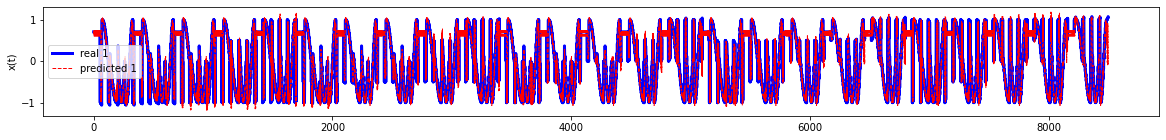

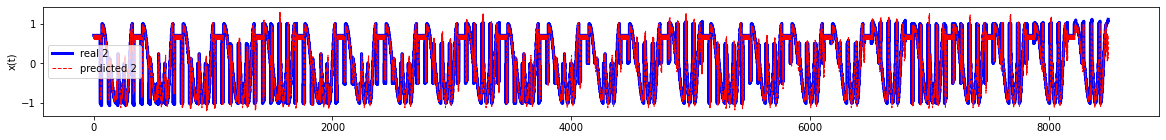

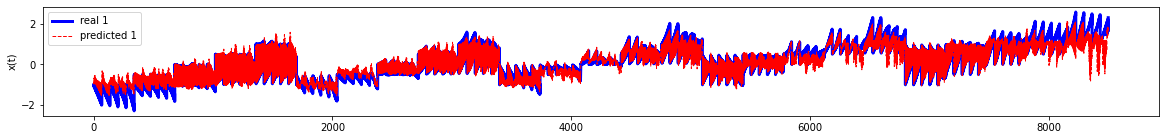

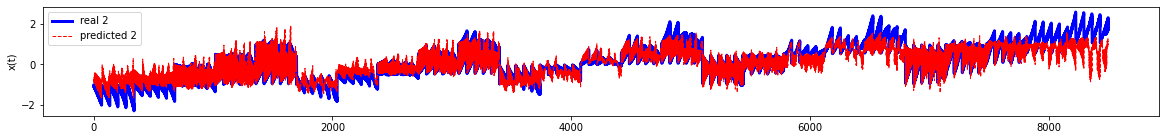

605
1.7031785249710083


In [9]:
# Hyperparameters
p   = 8           # size of branch and trunk ouput
n   = 4           # horizon window length
noi = 1           # number of inputs
noo = 2           # number of outputs
H   = 21          # maximum window length

# Create Dataset and DataLoader objects
src_file_train = 'C:/Users/tln229/Downloads/Python/2. DeepONets/0. Data/data_12.csv'
train_ds       = Data(src_file_train, n, H, noi, noo)
print("Number of training data: ", train_ds.y_data.shape[0])

src_file_test  = 'C:/Users/tln229/Downloads/Python/2. DeepONets/0. Data/data_13.csv'
test_ds        = Data(src_file_test, n, H, noi, noo)

# Create network
device = torch.device("cpu")
net = Net(n, p, noi, noo).to(device)

# train model
lr         = 0.001
min_epochs = 500
max_epochs = 100000
patience   = 200
R2_train, R2_test = train(net, train_ds, test_ds, lr, min_epochs, max_epochs, patience)

# plot
plot(net, train_ds, (20,2))
plot(net, test_ds,  (20,2))

# best model
print(np.argmax(R2_test))
print(np.max(R2_test))

# save
# PATH = 'C:/Users/tln229/Downloads/Python/2. DeepONets/0. Saved models/Stacked_conditioned_Tz.pt'
# torch.save(net, PATH)